In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder
from category_encoders.cat_boost import CatBoostEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

In [5]:
clustering_data = pd.read_csv('../exploration_data/clustering_data.csv')
drop_cols = ['index',
             'subject_id', 
             'hadm_id', 
             'icustay_id', 
             'admittime',
             'dischtime', 
             'los_hospital' ,
             'dod', 
             'category', 
             'first_category', 
             'pregnancy complications',
             'hospital_expire_flag',
             'ideal_ICU', 
             'FIRST_CAREUNIT',
             'INTIME', 
             'OUTTIME_COLLAPSED']


#drop not needed columns
clustering_data = clustering_data.drop(drop_cols, axis=1)

#drops nulls
clustering_data = clustering_data.dropna()


# Quick Exploration 

In [7]:
clustering_data['los_icu'].mean()

5.683791253454723

In [8]:
clustering_data['los_icu'].median()

2.0

(array([1.1397e+04, 5.5600e+02, 1.7600e+02, 7.4000e+01, 5.0000e+01,
        1.9000e+01, 1.5000e+01, 9.0000e+00, 5.0000e+00, 1.0000e+00]),
 array([  0. ,  17.2,  34.4,  51.6,  68.8,  86. , 103.2, 120.4, 137.6,
        154.8, 172. ]),
 <a list of 10 Patch objects>)

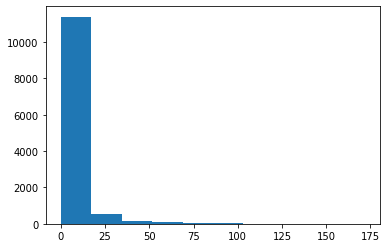

In [9]:
#data is right skewed
plt.hist(clustering_data['los_icu'])

In [10]:
#118 unique number of days for ICU LOS
print(1/len(clustering_data['los_icu'].unique())) # los=0 is 0.8% of possible icu days

#but takes up 11% of total data 
print(len(clustering_data[clustering_data['los_icu'] == 0])/len(clustering_data))

0.00847457627118644
0.11185173142578443


In [11]:
#outlier is >= 30 days
#using geometric mean + 2SD
print(clustering_data['los_icu'].mean() + (2*clustering_data['los_icu'].describe()['std']))


print(clustering_data['los_icu'].median() + (2*clustering_data['los_icu'].describe()['std']))

29.064690144752824
25.380898891298102


In [12]:
#proportion of data 3.6%
print(len(clustering_data[clustering_data['los_icu']>=25])/len(clustering_data)) 


#as a porportion of total inpatient days (34%)
clustering_data[clustering_data['los_icu']>=25]['los_icu'].sum()/clustering_data['los_icu'].sum()

0.04763453097057389


0.39831526558164815

In [13]:
clustering_data['los_icu'].sum()

69922.0

In [14]:
clustering_data.columns

Index(['gender', 'ethnicity_grouped', 'admission_type', 'hospstay_seq',
       'first_hosp_stay', 'los_icu', 'icustay_seq', 'first_icu_stay', 'blood',
       'circulatory', 'congenital', 'digestive', 'genitourinary',
       'ill-defined', 'infectious|parasitic', 'injury|poisoning', 'mental',
       'metabolic|immunity', 'musculoskeletal', 'neoplasms', 'nervous',
       'perinatal', 'respiratory', 'skin', 'unclassified', 'age_group',
       'dod_exists', 'sepsis', 'diagnoses_count', 'INTIME_COLLAPSED_day'],
      dtype='object')

# Assign groups

In [15]:
group1 = clustering_data[clustering_data['los_icu'] == 0]
group1['cluster'] = 1

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
group2 = clustering_data[(clustering_data['los_icu'] >= 1) & (clustering_data['los_icu'] <= 7)]
group2['cluster'] = 2

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
group3 = clustering_data[(clustering_data['los_icu'] >= 8) & (clustering_data['los_icu'] <= 25)]
group3['cluster'] = 3

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
group4 = clustering_data[ clustering_data['los_icu'] >= 26]
group4['cluster'] = 4

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
#checks
print(len(group1) + len(group2) + len(group3) + len(group4)  )
print(len(clustering_data))

12302
12302


In [20]:
clustering_data = pd.concat([group1, group2, group3, group4])
print(len(clustering_data))

12302


In [21]:
print(len(group1)/len(clustering_data))
print(len(group2)/len(clustering_data))
print(len(group3)/len(clustering_data))
print(len(group4)/len(clustering_data))


0.11185173142578443
0.7147618273451471
0.128515688505934
0.04487075272313445


In [22]:
print(group1['los_icu'].sum()/clustering_data['los_icu'].sum())
print(group2['los_icu'].sum()/clustering_data['los_icu'].sum())
print(group3['los_icu'].sum()/clustering_data['los_icu'].sum())
print(group4['los_icu'].sum()/clustering_data['los_icu'].sum())

0.0
0.309287491776551
0.30455364549068964
0.38615886273275934


In [23]:
len(clustering_data[clustering_data['los_icu']==0]['los_icu'])

1376

In [24]:
group1['los_icu'].mean()

0.0

In [216]:
len(group1)

1376

In [217]:
clustering_data['cluster']

5        1
17       1
22       1
33       1
34       1
        ..
12197    4
12223    4
12236    4
12260    4
12303    4
Name: cluster, Length: 12302, dtype: int64

# Supervised learning - cat Boost

In [218]:
#clustering_data = pd.concat([group1, group2, group3, group4])
#clustering_data = clustering_data.dropna()
#clustering_data = clustering_data.drop('los_icu', axis=1)

In [219]:
clustering_data

,gender,ethnicity_grouped,admission_type,hospstay_seq,first_hosp_stay,los_icu,icustay_seq,first_icu_stay,blood,circulatory,...,perinatal,respiratory,skin,unclassified,age_group,dod_exists,sepsis,diagnoses_count,INTIME_COLLAPSED_day,cluster
5,F,white,NEWBORN,1.0,True,0.0,1.0,True,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0-19.0,False,False,6.0,2000-12-31,1
17,F,asian,NEWBORN,1.0,True,0.0,1.0,True,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0-19.0,False,False,3.0,2001-01-01,1
22,M,asian,NEWBORN,1.0,True,0.0,1.0,True,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0-19.0,False,False,4.0,2001-01-02,1
33,F,black,NEWBORN,1.0,True,0.0,1.0,True,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0-19.0,False,False,2.0,2001-01-03,1
34,M,white,EMERGENCY,1.0,True,0.0,1.0,True,1.0,2.0,...,0.0,0.0,0.0,0.0,40.0-59.0,True,False,8.0,2001-01-03,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12197,F,white,NEWBORN,1.0,True,95.0,1.0,True,0.0,0.0,...,11.0,0.0,0.0,0.0,0.0-19.0,False,False,13.0,2003-02-24,4
12223,M,black,EMERGENCY,3.0,False,51.0,1.0,True,1.0,3.0,...,0.0,4.0,1.0,2.0,40.0-59.0,True,False,18.0,2003-02-25,4
12236,M,white,NEWBORN,1.0,True,36.0,1.0,True,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0-19.0,False,False,7.0,2003-02-26,4
12260,M,unknown,NEWBORN,1.0,True,46.0,1.0,True,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0-19.0,False,False,13.0,2003-02-27,4


In [220]:
categorical= ['gender', 
                         'ethnicity_grouped', 
                         'admission_type', 
                         'first_hosp_stay',
                         'first_icu_stay', 
                         'age_group', 
                         'dod_exists',
                         'sepsis',
                         'INTIME_COLLAPSED_day']

numerical = clustering_data[clustering_data.columns.difference(categorical)].columns


In [221]:
y_col = 'cluster'

In [222]:
#80% train/test, 20% unseen/validation
seen, unseen = train_test_split(clustering_data, test_size=0.2, random_state=42)

#X and y for train and test
X = seen.drop([y_col], axis=1)
y = seen[y_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#x and y for unseen/validation data
X_validate, y_validate = unseen.drop([y_col], axis=1), unseen[y_col]


In [223]:
y_train

9674     4
3565     2
4861     2
5819     2
10246    2
        ..
5410     2
6790     2
1160     2
7264     2
9956     2
Name: cluster, Length: 6888, dtype: int64

In [224]:
def target_coder(train_x, train_y, test_x, test_y, unseen_x, unseen_y):
    coder = CatBoostEncoder(cols=categorical, sigma = 2, a=2, return_df=True).fit(train_x, train_y)
    train_x = coder.transform(train_x)
    test_x = coder.transform(test_x)
    unseen_x = coder.transform(unseen_x)
    return (train_x, train_y, test_x, test_y, unseen_x, unseen_y)

In [225]:
X_train, y_train, X_test, y_test, X_validate, y_validate = target_coder(X_train, y_train, X_test, y_test, X_validate, y_validate)



In [226]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
model = RandomForestClassifier()

#train model
model.fit(X_train, y_train)

predicted_labels = model.predict(X_test)

accuracy_score(y_test, predicted_labels)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9905181171689807

In [227]:
def match_x_test_with_predictions(X_test):
    predictions = np.ndarray.round(model.predict(X_test))
    x_test_indexes = X_test.index.to_list()
    
    df = pd.DataFrame()
    df = seen.loc[x_test_indexes]
    df['model_predictions'] = predictions
    df['los_icu'] = y_test
    return df

In [228]:
predicted_df = match_x_test_with_predictions(X_test)

#correct predictions
#correct_predictions_df = predicted_df[predicted_df['model_predictions'] == predicted_df['cluster']]


In [229]:
#getting feature importances
names = X_train.columns

sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), names), 
             reverse=True)

[(0.5855, 'los_icu'),
 (0.1063, 'perinatal'),
 (0.0643, 'diagnoses_count'),
 (0.0348, 'INTIME_COLLAPSED_day'),
 (0.0291, 'admission_type'),
 (0.0277, 'infectious|parasitic'),
 (0.0195, 'age_group'),
 (0.0158, 'circulatory'),
 (0.0133, 'respiratory'),
 (0.0116, 'metabolic|immunity'),
 (0.0112, 'ill-defined'),
 (0.0092, 'ethnicity_grouped'),
 (0.0082, 'injury|poisoning'),
 (0.0065, 'sepsis'),
 (0.006, 'digestive'),
 (0.0054, 'gender'),
 (0.0054, 'congenital'),
 (0.0052, 'nervous'),
 (0.0051, 'blood'),
 (0.0048, 'unclassified'),
 (0.0042, 'dod_exists'),
 (0.0038, 'genitourinary'),
 (0.0028, 'mental'),
 (0.0026, 'first_hosp_stay'),
 (0.0024, 'neoplasms'),
 (0.0024, 'hospstay_seq'),
 (0.002, 'skin'),
 (0.002, 'icustay_seq'),
 (0.0017, 'musculoskeletal'),
 (0.0015, 'first_icu_stay')]

# Explore What distinguishes these groups. guided by cat boost importances

# Group 1 - Important Features
- in group 1, age should only by 0=19
- admission_type = newborn
- perinatal > 0

Text(0.5, 69.00000000000009, 'Age_group')

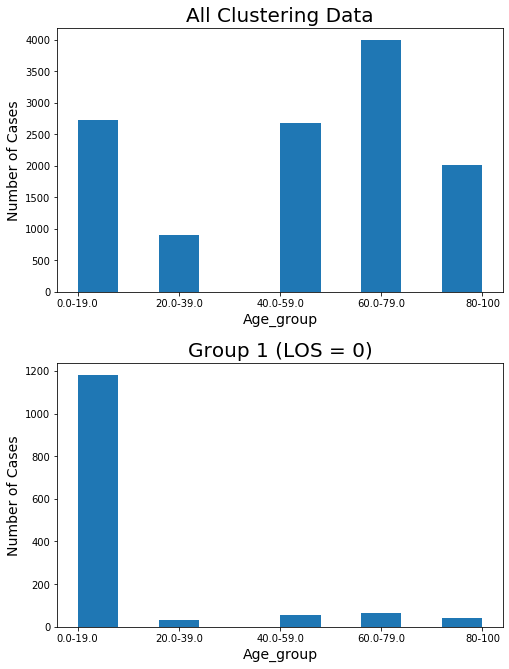

In [230]:
#admission type more likely to be newborn much more than rest of data

fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='age_group')['age_group'])
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_ylabel('Number of Cases', fontsize=14)
ax[0].set_xlabel('Age_group', fontsize=14)


ax[1].hist(group1.sort_values(by='age_group')['age_group'])
ax[1].set_title('Group 1 (LOS = 0)', fontsize=20)
ax[1].set_ylabel('Number of Cases', fontsize=14)
ax[1].set_xlabel('Age_group', fontsize=14)


Text(45.125, 0.5, 'Number of Cases')

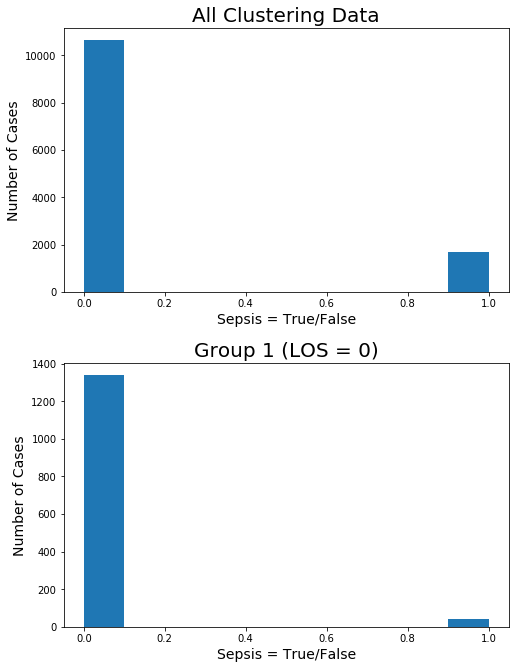

In [231]:
#admission type more likely to be newborn much more than rest of data

fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='sepsis')['sepsis'].astype(int))
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_xlabel('Sepsis = True/False', fontsize=14)
ax[0].set_ylabel('Number of Cases', fontsize=14)


ax[1].hist(group1.sort_values(by='sepsis')['sepsis'].astype(int))
ax[1].set_title('Group 1 (LOS = 0)', fontsize=20)
ax[1].set_xlabel('Sepsis = True/False', fontsize=14)
ax[1].set_ylabel('Number of Cases', fontsize=14)


Text(47.125, 0.5, 'Number of Cases')

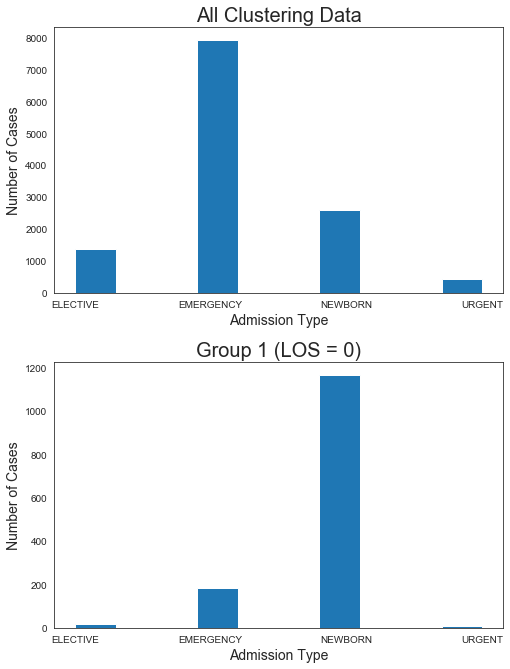

In [453]:
#admission type more likely to be newborn much more than rest of data

fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='admission_type')['admission_type'])
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_xlabel('Admission Type', fontsize=14)
ax[0].set_ylabel('Number of Cases', fontsize=14)


ax[1].hist(group1.sort_values(by='admission_type')['admission_type'])
ax[1].set_title('Group 1 (LOS = 0)', fontsize=20)
ax[1].set_xlabel('Admission Type', fontsize=14)
ax[1].set_ylabel('Number of Cases', fontsize=14)




Text(47.125, 0.5, 'Number of Cases')

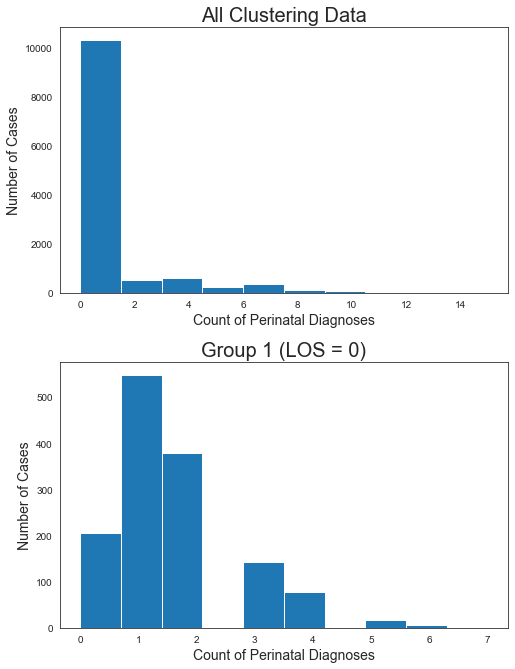

In [454]:

fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='perinatal')['perinatal'])
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_xlabel('Count of Perinatal Diagnoses', fontsize=14)
ax[0].set_ylabel('Number of Cases', fontsize=14)


ax[1].hist(group1.sort_values(by='perinatal')['perinatal'])
ax[1].set_title('Group 1 (LOS = 0)', fontsize=20)
ax[1].set_xlabel('Count of Perinatal Diagnoses', fontsize=14)
ax[1].set_ylabel('Number of Cases', fontsize=14)



Text(0.5, 69.00000000000009, 'Number of Diagnoses')

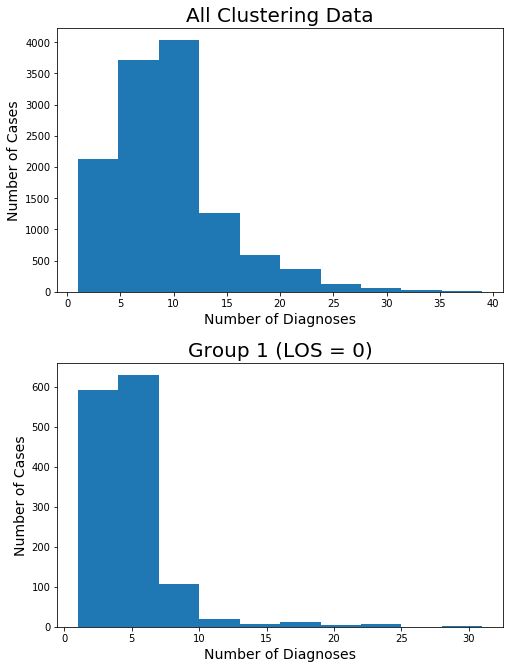

In [122]:
#admission type more likely to be newborn much more than rest of data

fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='diagnoses_count')['diagnoses_count'])
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_ylabel('Number of Cases', fontsize=14)
ax[0].set_xlabel('Number of Diagnoses', fontsize=14)


ax[1].hist(group1.sort_values(by='diagnoses_count')['diagnoses_count'])
ax[1].set_title('Group 1 (LOS = 0)', fontsize=20)
ax[1].set_ylabel('Number of Cases', fontsize=14)
ax[1].set_xlabel('Number of Diagnoses', fontsize=14)


# Group 1 - Unimportant Features

'dod_exists'),
 (0.0038, 'genitourinary'),
 (0.0028, 'mental'),
 (0.0026, 'first_hosp_stay'),
 (0.0024, 'neoplasms'),
 (0.0024, 'hospstay_seq'),
 (0.002, 'skin'),
 (0.002, 'icustay_seq'),
 (0.0017, 'musculoskeletal'),
 (0.0015, 'first_icu_stay')]

Text(0.5, 69.00000000000009, 'Number of Diagnoses')

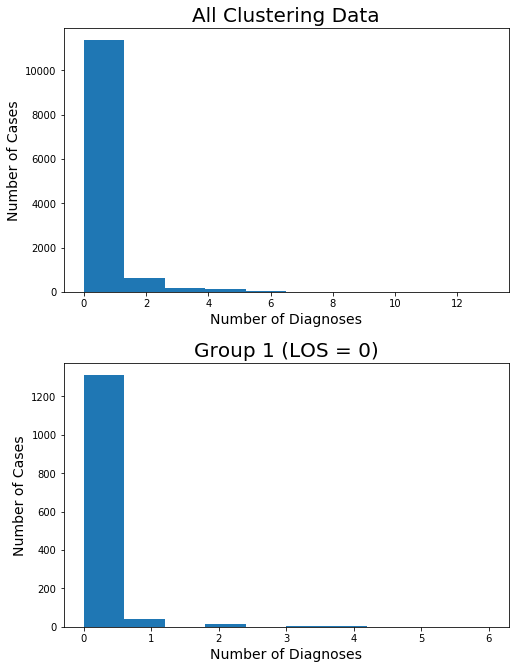

In [235]:
fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='mental')['mental'])
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_ylabel('Number of Cases', fontsize=14)
ax[0].set_xlabel('Number of Diagnoses', fontsize=14)


ax[1].hist(group1.sort_values(by='mental')['mental'])
ax[1].set_title('Group 1 (LOS = 0)', fontsize=20)
ax[1].set_ylabel('Number of Cases', fontsize=14)
ax[1].set_xlabel('Number of Diagnoses', fontsize=14)

Text(0.5, 69.00000000000009, 'Number of Diagnoses')

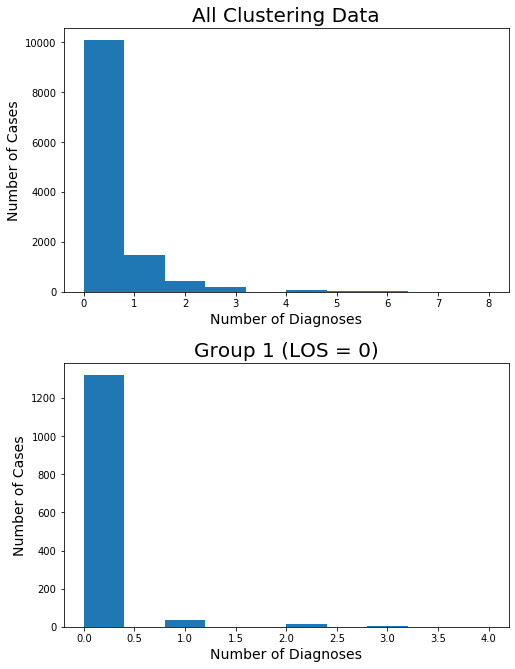

In [232]:
fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='neoplasms')['neoplasms'])
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_ylabel('Number of Cases', fontsize=14)
ax[0].set_xlabel('Number of Diagnoses', fontsize=14)


ax[1].hist(group1.sort_values(by='neoplasms')['neoplasms'])
ax[1].set_title('Group 1 (LOS = 0)', fontsize=20)
ax[1].set_ylabel('Number of Cases', fontsize=14)
ax[1].set_xlabel('Number of Diagnoses', fontsize=14)

# Group 2

Text(45.125, 0.5, 'Number of Cases')

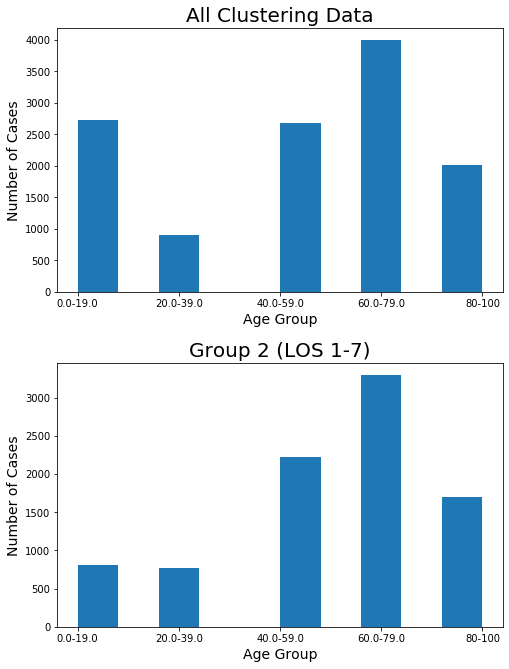

In [111]:
fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='age_group')['age_group'])
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_xlabel('Age Group', fontsize=14)
ax[0].set_ylabel('Number of Cases', fontsize=14)


ax[1].hist(group2.sort_values(by='age_group')['age_group'])
ax[1].set_title('Group 2 (LOS 1-7)', fontsize=20)
ax[1].set_xlabel('Age Group', fontsize=14)
ax[1].set_ylabel('Number of Cases', fontsize=14)


Text(45.125, 0.5, 'Number of Cases')

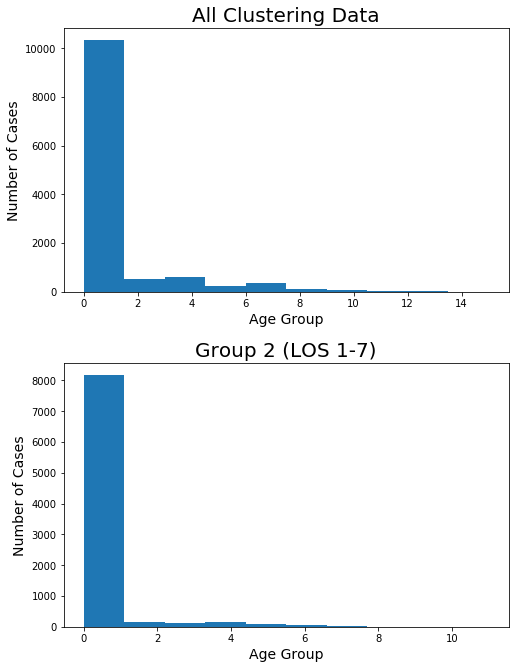

In [118]:
fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='perinatal')['perinatal'].astype(int))
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_xlabel('Age Group', fontsize=14)
ax[0].set_ylabel('Number of Cases', fontsize=14)


ax[1].hist(group2.sort_values(by='perinatal')['perinatal'].astype(int))
ax[1].set_title('Group 2 (LOS 1-7)', fontsize=20)
ax[1].set_xlabel('Age Group', fontsize=14)
ax[1].set_ylabel('Number of Cases', fontsize=14)


Text(45.125, 0.5, 'Number of Cases')

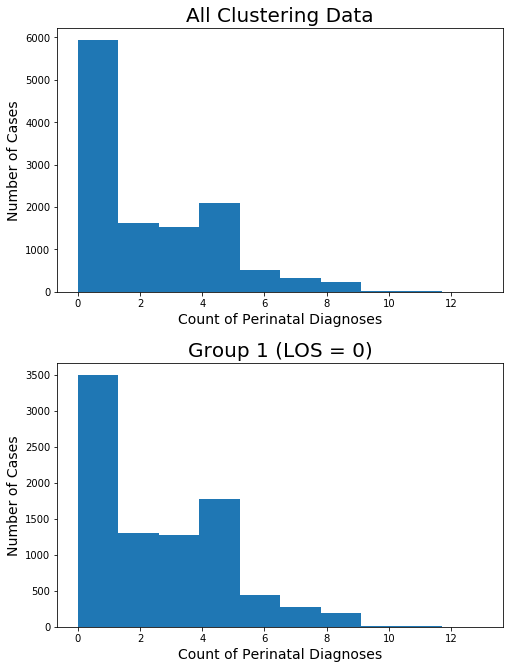

In [97]:

fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='circulatory')['circulatory'].astype(int))
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_xlabel('Count of Perinatal Diagnoses', fontsize=14)
ax[0].set_ylabel('Number of Cases', fontsize=14)


ax[1].hist(group2.sort_values(by='circulatory')['circulatory'].astype(int))
ax[1].set_title('Group 1 (LOS = 0)', fontsize=20)
ax[1].set_xlabel('Count of Perinatal Diagnoses', fontsize=14)
ax[1].set_ylabel('Number of Cases', fontsize=14)


# Group 3

Text(47.125, 0.5, 'Number of Cases')

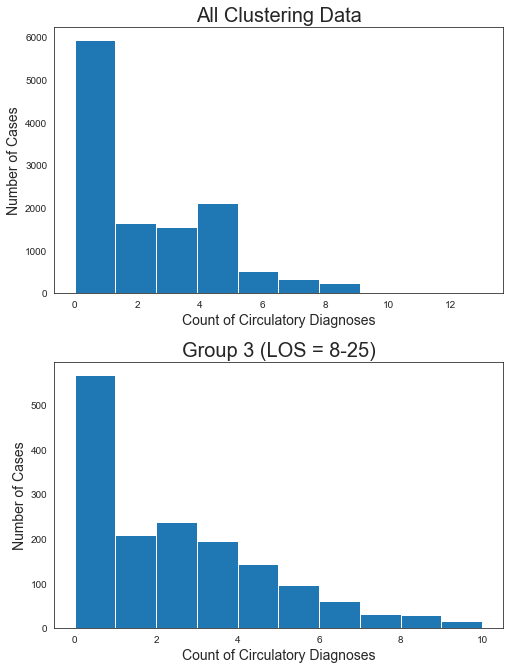

In [465]:
#circulatory > 1
fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='circulatory')['circulatory'])
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_xlabel('Count of Circulatory Diagnoses', fontsize=14)
ax[0].set_ylabel('Number of Cases', fontsize=14)


ax[1].hist(group3.sort_values(by='circulatory')['circulatory'])
ax[1].set_title('Group 3 (LOS = 8-25)', fontsize=20)
ax[1].set_xlabel('Count of Circulatory Diagnoses', fontsize=14)
ax[1].set_ylabel('Number of Cases', fontsize=14)


Text(45.125, 0.5, 'Number of Cases')

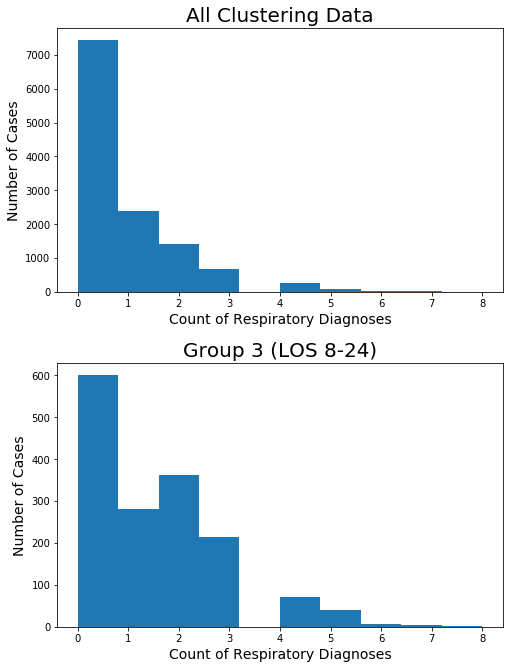

In [98]:
#respiratory for group 3
fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='respiratory')['respiratory'])
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_xlabel('Count of Respiratory Diagnoses', fontsize=14)
ax[0].set_ylabel('Number of Cases', fontsize=14)


ax[1].hist(group3.sort_values(by='respiratory')['respiratory'])
ax[1].set_title('Group 3 (LOS 8-24)', fontsize=20)
ax[1].set_xlabel('Count of Respiratory Diagnoses', fontsize=14)
ax[1].set_ylabel('Number of Cases', fontsize=14)


Text(45.125, 0.5, 'Number of Cases')

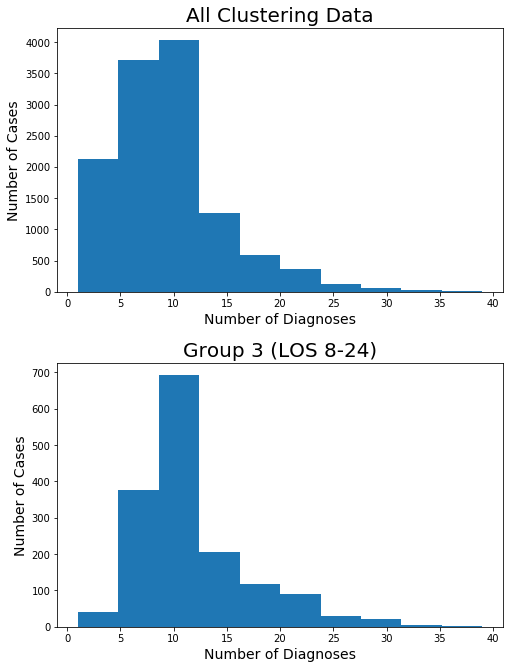

In [100]:
#diagnoses_count > 10
fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='diagnoses_count')['diagnoses_count'])
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_xlabel('Number of Diagnoses', fontsize=14)
ax[0].set_ylabel('Number of Cases', fontsize=14)


ax[1].hist(group3.sort_values(by='diagnoses_count')['diagnoses_count'])
ax[1].set_title('Group 3 (LOS 8-24)', fontsize=20)
ax[1].set_xlabel('Number of Diagnoses', fontsize=14)
ax[1].set_ylabel('Number of Cases', fontsize=14)

Text(45.125, 0.5, 'Number of Cases')

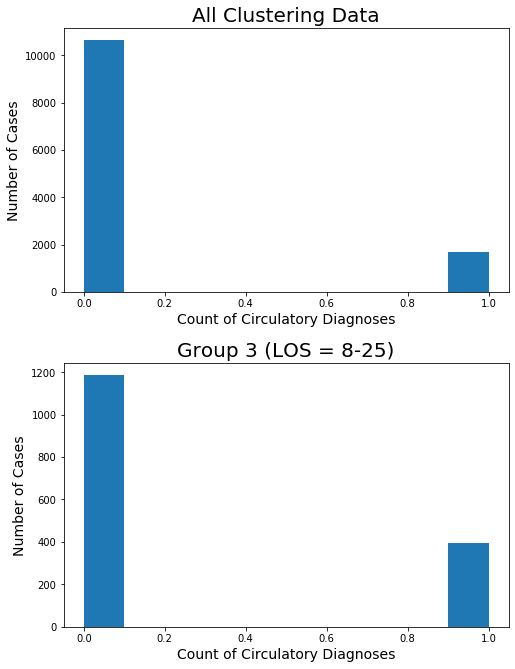

In [124]:
#circulatory > 1
fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='sepsis')['sepsis'].astype(int))
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_xlabel('Count of Circulatory Diagnoses', fontsize=14)
ax[0].set_ylabel('Number of Cases', fontsize=14)


ax[1].hist(group3.sort_values(by='sepsis')['sepsis'].astype(int))
ax[1].set_title('Group 3 (LOS = 8-25)', fontsize=20)
ax[1].set_xlabel('Count of Circulatory Diagnoses', fontsize=14)
ax[1].set_ylabel('Number of Cases', fontsize=14)


Text(45.125, 0.5, 'Number of Cases')

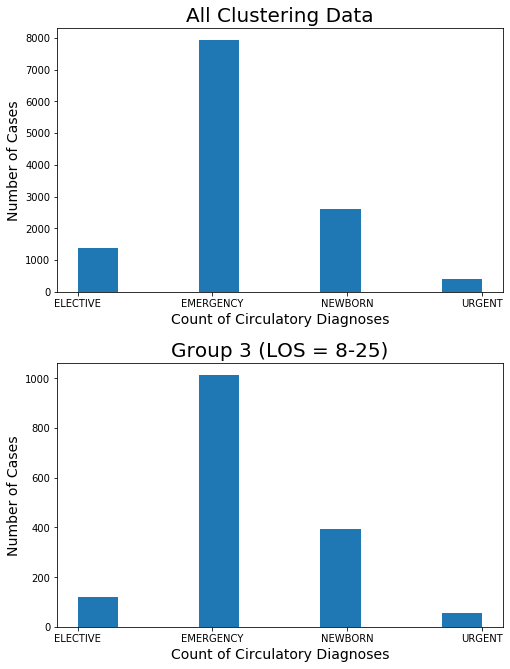

In [123]:
#circulatory > 1
fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='admission_type')['admission_type'])
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_xlabel('Count of Circulatory Diagnoses', fontsize=14)
ax[0].set_ylabel('Number of Cases', fontsize=14)


ax[1].hist(group3.sort_values(by='admission_type')['admission_type'])
ax[1].set_title('Group 3 (LOS = 8-25)', fontsize=20)
ax[1].set_xlabel('Count of Circulatory Diagnoses', fontsize=14)
ax[1].set_ylabel('Number of Cases', fontsize=14)


Text(45.125, 0.5, 'Number of Cases')

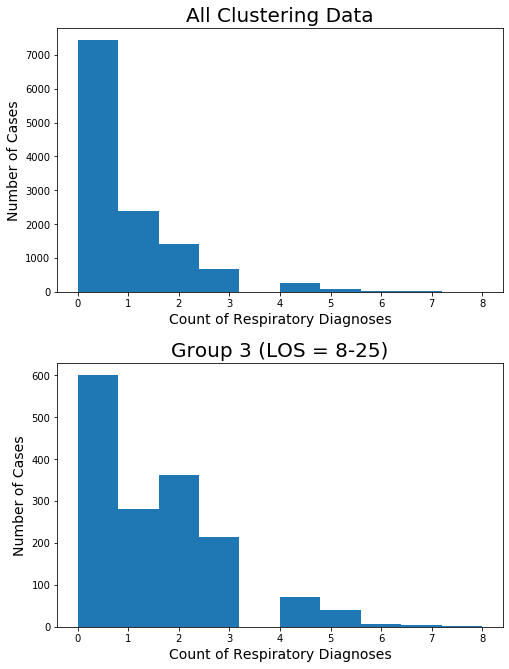

In [127]:
#circulatory > 1
fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='respiratory')['respiratory'])
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_xlabel('Count of Respiratory Diagnoses', fontsize=14)
ax[0].set_ylabel('Number of Cases', fontsize=14)


ax[1].hist(group3.sort_values(by='respiratory')['respiratory'])
ax[1].set_title('Group 3 (LOS = 8-25)', fontsize=20)
ax[1].set_xlabel('Count of Respiratory Diagnoses', fontsize=14)
ax[1].set_ylabel('Number of Cases', fontsize=14)


In [136]:
clustering_data[clustering_data['congenital']>0]['los_icu'].mean()

17.907983761840324

Text(45.125, 0.5, 'Number of Cases')

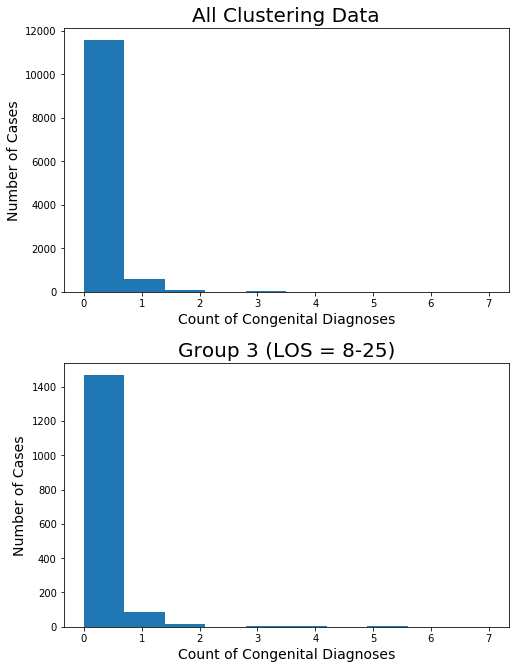

In [129]:
#circulatory > 1
fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='congenital')['congenital'])
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_xlabel('Count of Congenital Diagnoses', fontsize=14)
ax[0].set_ylabel('Number of Cases', fontsize=14)


ax[1].hist(group3.sort_values(by='congenital')['congenital'])
ax[1].set_title('Group 3 (LOS = 8-25)', fontsize=20)
ax[1].set_xlabel('Count of Congenital Diagnoses', fontsize=14)
ax[1].set_ylabel('Number of Cases', fontsize=14)


# Group 4
- diagnoses_count ?

Text(45.125, 0.5, 'Number of Cases')

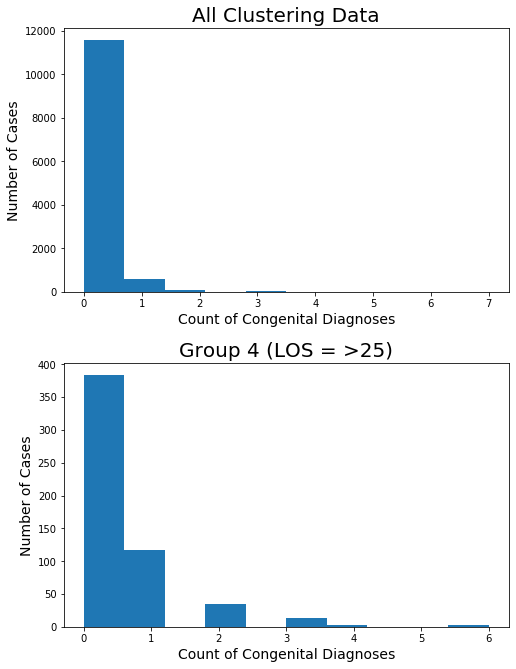

In [138]:
#age group
#when anything but 20-39
fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='congenital')['congenital'])
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_xlabel('Count of Congenital Diagnoses', fontsize=14)
ax[0].set_ylabel('Number of Cases', fontsize=14)


ax[1].hist(group4.sort_values(by='congenital')['congenital'])
ax[1].set_title('Group 4 (LOS = >25)', fontsize=20)
ax[1].set_xlabel('Count of Congenital Diagnoses', fontsize=14)
ax[1].set_ylabel('Number of Cases', fontsize=14)


Text(45.125, 0.5, 'Number of Cases')

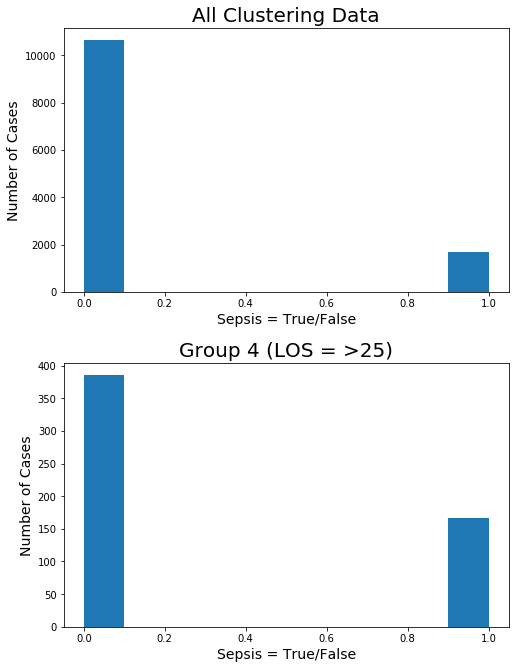

In [140]:
#age group
#when anything but 20-39
fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='sepsis')['sepsis'].astype(int))
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_xlabel('Sepsis = True/False', fontsize=14)
ax[0].set_ylabel('Number of Cases', fontsize=14)


ax[1].hist(group4.sort_values(by='sepsis')['sepsis'].astype(int))
ax[1].set_title('Group 4 (LOS = >25)', fontsize=20)
ax[1].set_xlabel('Sepsis = True/False', fontsize=14)
ax[1].set_ylabel('Number of Cases', fontsize=14)


Text(45.125, 0.5, 'Number of Cases')

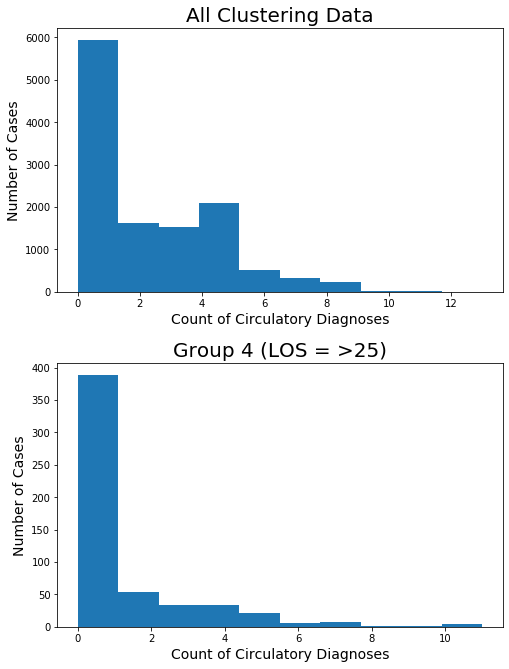

In [101]:
#age group
#when anything but 20-39
fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='circulatory')['circulatory'])
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_xlabel('Count of Circulatory Diagnoses', fontsize=14)
ax[0].set_ylabel('Number of Cases', fontsize=14)


ax[1].hist(group4.sort_values(by='circulatory')['circulatory'])
ax[1].set_title('Group 4 (LOS = >25)', fontsize=20)
ax[1].set_xlabel('Count of Circulatory Diagnoses', fontsize=14)
ax[1].set_ylabel('Number of Cases', fontsize=14)


Text(47.125, 0.5, 'Number of Cases')

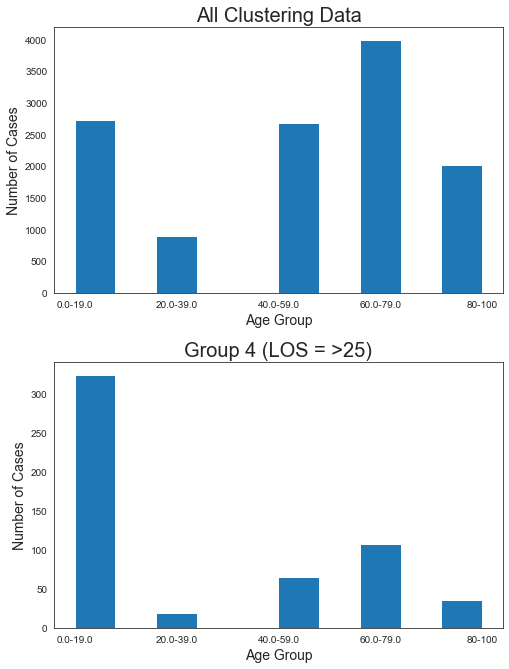

In [461]:
#age group
#when anything but 20-39
fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='age_group')['age_group'])
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_xlabel('Age Group', fontsize=14)
ax[0].set_ylabel('Number of Cases', fontsize=14)


ax[1].hist(group4.sort_values(by='age_group')['age_group'])
ax[1].set_title('Group 4 (LOS = >25)', fontsize=20)
ax[1].set_xlabel('Age Group', fontsize=14)
ax[1].set_ylabel('Number of Cases', fontsize=14)



Text(45.125, 0.5, 'Number of Cases')

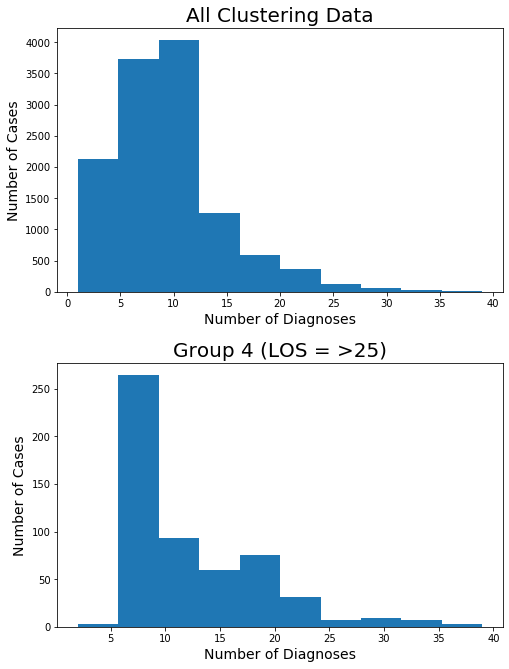

In [165]:
#diagnoses count
fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='diagnoses_count')['diagnoses_count'])
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_xlabel('Number of Diagnoses', fontsize=14)
ax[0].set_ylabel('Number of Cases', fontsize=14)


ax[1].hist(group4.sort_values(by='diagnoses_count')['diagnoses_count'])
ax[1].set_title('Group 4 (LOS = >25)', fontsize=20)
ax[1].set_xlabel('Number of Diagnoses', fontsize=14)
ax[1].set_ylabel('Number of Cases', fontsize=14)



Text(45.125, 0.5, 'Number of Cases')

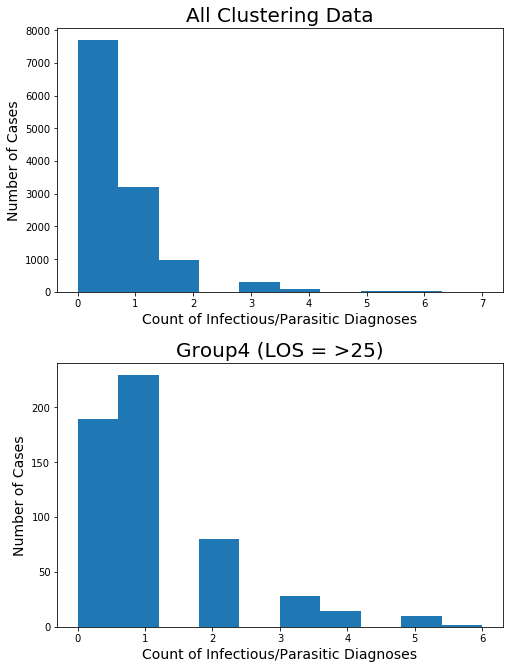

In [104]:
#infectious|parasitic
fig, ax = plt.subplots(nrows=2, figsize=(8, 10))
fig.tight_layout(pad=5.0)

ax[0].hist(clustering_data.sort_values(by='infectious|parasitic')['infectious|parasitic'])
ax[0].set_title('All Clustering Data', fontsize=20)
ax[0].set_xlabel('Count of Infectious/Parasitic Diagnoses', fontsize=14)
ax[0].set_ylabel('Number of Cases', fontsize=14)


ax[1].hist(group4.sort_values(by='infectious|parasitic')['infectious|parasitic'])
ax[1].set_title('Group4 (LOS = >25)', fontsize=20)
ax[1].set_xlabel('Count of Infectious/Parasitic Diagnoses', fontsize=14)
ax[1].set_ylabel('Number of Cases', fontsize=14)



In [170]:
#turn from float to integer
clustering_data['los_icu'] = clustering_data['los_icu'].astype(int)

# log transform
clustering_data['log_los_icu'] = np.log(clustering_data['los_icu'])

#round
clustering_data['log_los_icu'] = round(clustering_data['log_los_icu'])



/usr/local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(array([1.1397e+04, 5.5600e+02, 1.7600e+02, 7.4000e+01, 5.0000e+01,
        1.9000e+01, 1.5000e+01, 9.0000e+00, 5.0000e+00, 1.0000e+00]),
 array([  0. ,  17.2,  34.4,  51.6,  68.8,  86. , 103.2, 120.4, 137.6,
        154.8, 172. ]),
 <a list of 10 Patch objects>)

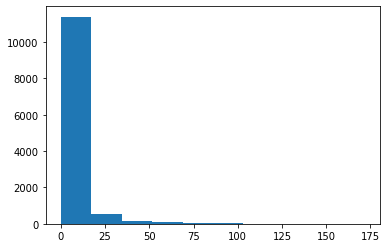

In [171]:
plt.hist(clustering_data['los_icu'])

In [172]:
clustering_data['log_los_icu'].unique()

array([  1.,   3.,   2., -inf,   0.,   4.,   5.])

In [173]:
df = clustering_data.loc[(clustering_data['log_los_icu'] >= 0)]

(array([3335.,    0., 4267.,    0., 2023.,    0.,  934.,    0.,  324.,
          43.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

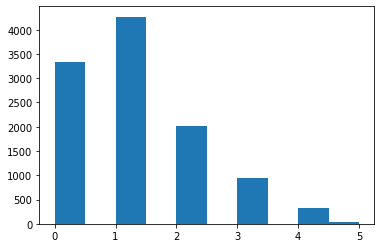

In [174]:
plt.hist(df['log_los_icu'])

In [175]:

y_col = 'log_los_icu'

#80% train/test, 20% unseen/validation
seen, unseen = train_test_split(df, test_size=0.2, random_state=42)

#X and y for train and test
X = seen.drop([y_col], axis=1)
y = seen[y_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#x and y for unseen/validation data
X_validate, y_validate = unseen.drop([y_col], axis=1), unseen[y_col]


In [176]:
X_train, y_train, X_test, y_test, X_validate, y_validate = target_coder(X_train, y_train, X_test, y_test, X_validate, y_validate)



In [177]:
X_train.columns

Index(['gender', 'ethnicity_grouped', 'admission_type', 'hospstay_seq',
       'first_hosp_stay', 'los_icu', 'icustay_seq', 'first_icu_stay', 'blood',
       'circulatory', 'congenital', 'digestive', 'genitourinary',
       'ill-defined', 'infectious|parasitic', 'injury|poisoning', 'mental',
       'metabolic|immunity', 'musculoskeletal', 'neoplasms', 'nervous',
       'perinatal', 'respiratory', 'skin', 'unclassified', 'age_group',
       'dod_exists', 'sepsis', 'diagnoses_count', 'INTIME_COLLAPSED_day'],
      dtype='object')

In [178]:
X_train

,gender,ethnicity_grouped,admission_type,hospstay_seq,first_hosp_stay,los_icu,icustay_seq,first_icu_stay,blood,circulatory,...,nervous,perinatal,respiratory,skin,unclassified,age_group,dod_exists,sepsis,diagnoses_count,INTIME_COLLAPSED_day
3308,1.159954,1.146080,1.952168,1.0,1.165722,15,1.0,1.157951,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,1.900654,1.135079,1.081633,11.0,1.360848
2061,1.159954,1.146080,0.923092,1.0,1.165722,1,1.0,1.157951,0.0,1.0,...,0.0,0.0,2.0,0.0,2.0,0.991257,1.135079,1.081633,11.0,0.858853
2700,1.159954,1.146080,0.923092,1.0,1.165722,1,1.0,1.157951,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.109134,1.135079,1.081633,5.0,0.781930
5109,1.170457,1.146080,1.062077,1.0,1.165722,3,1.0,1.157951,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.109134,1.135079,1.081633,9.0,1.351676
6271,1.170457,1.167583,1.062077,1.0,1.165722,1,1.0,1.157951,1.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.914600,1.135079,1.081633,4.0,0.797506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,1.159954,1.191035,1.184466,1.0,1.165722,7,1.0,1.157951,0.0,5.0,...,0.0,0.0,2.0,0.0,0.0,1.109134,1.199420,1.081633,9.0,1.286949
3290,1.170457,1.191035,0.923092,1.0,1.165722,3,1.0,1.157951,0.0,3.0,...,0.0,0.0,1.0,0.0,1.0,1.109134,1.199420,1.081633,9.0,1.016509
4779,1.159954,1.167583,1.062077,1.0,1.165722,3,1.0,1.157951,1.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.914600,1.135079,1.081633,11.0,1.016509
6566,1.170457,1.191035,0.923092,1.0,1.165722,3,1.0,1.157951,0.0,5.0,...,0.0,0.0,1.0,0.0,0.0,1.044413,1.199420,1.081633,6.0,0.892064


In [179]:
y_train

3308    3.0
2061    0.0
2700    0.0
5109    1.0
6271    0.0
       ... 
1077    2.0
3290    1.0
4779    1.0
6566    1.0
3197    1.0
Name: log_los_icu, Length: 6118, dtype: float64

In [183]:
scaled_data = pd.concat([X_train, y_train], axis=1)

In [185]:
kmeans = KMeans(n_clusters = 4, random_state = 123)
kmeans.fit(scaled_data)
#print(scaled_data.cluster_centers_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [186]:
print(kmeans.labels_)

[3 0 0 ... 0 0 0]


In [188]:
len(kmeans.labels_)

6118

In [189]:
len(X_train)

6118

In [195]:
x_train_indexes = X_train.index.to_list() #indexes for x train

In [196]:
df1 = clustering_data.loc[x_train_indexes]

In [197]:
df1['predictions'] = kmeans.labels_

In [198]:
df1

,gender,ethnicity_grouped,admission_type,hospstay_seq,first_hosp_stay,los_icu,icustay_seq,first_icu_stay,blood,circulatory,...,respiratory,skin,unclassified,age_group,dod_exists,sepsis,diagnoses_count,INTIME_COLLAPSED_day,log_los_icu,predictions
3308,M,white,NEWBORN,1.0,True,15,1.0,True,0.0,0.0,...,0.0,0.0,0.0,0.0-19.0,False,False,11.0,2001-08-11,3.0,3
2061,M,white,ELECTIVE,1.0,True,1,1.0,True,0.0,1.0,...,2.0,0.0,2.0,40.0-59.0,False,False,11.0,2001-05-23,0.0,0
2700,M,white,ELECTIVE,1.0,True,1,1.0,True,0.0,3.0,...,0.0,0.0,0.0,60.0-79.0,False,False,5.0,2001-07-04,0.0,0
5109,F,white,EMERGENCY,1.0,True,3,1.0,True,0.0,1.0,...,0.0,0.0,0.0,60.0-79.0,False,False,9.0,2001-12-07,1.0,0
6271,F,black,EMERGENCY,1.0,True,1,1.0,True,1.0,0.0,...,2.0,0.0,0.0,20.0-39.0,False,False,4.0,2002-02-14,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,M,unknown,URGENT,1.0,True,7,1.0,True,0.0,5.0,...,2.0,0.0,0.0,60.0-79.0,True,False,9.0,2001-03-15,2.0,0
3290,F,unknown,ELECTIVE,1.0,True,3,1.0,True,0.0,3.0,...,1.0,0.0,1.0,60.0-79.0,True,False,9.0,2001-08-10,1.0,0
4779,M,black,EMERGENCY,1.0,True,3,1.0,True,1.0,0.0,...,0.0,0.0,2.0,20.0-39.0,False,False,11.0,2001-11-15,1.0,0
6566,F,unknown,ELECTIVE,1.0,True,3,1.0,True,0.0,5.0,...,1.0,0.0,0.0,80-100,True,False,6.0,2002-03-05,1.0,0


In [200]:
df1[df1['predictions']==1]

,gender,ethnicity_grouped,admission_type,hospstay_seq,first_hosp_stay,los_icu,icustay_seq,first_icu_stay,blood,circulatory,...,respiratory,skin,unclassified,age_group,dod_exists,sepsis,diagnoses_count,INTIME_COLLAPSED_day,log_los_icu,predictions
5349,F,white,NEWBORN,1.0,True,106,1.0,True,0.0,2.0,...,0.0,0.0,0.0,0.0-19.0,False,False,20.0,2001-12-20,5.0,1
10013,F,black,NEWBORN,1.0,True,172,1.0,True,0.0,0.0,...,1.0,0.0,0.0,0.0-19.0,False,True,9.0,2002-10-14,5.0,1
11548,M,white,NEWBORN,1.0,True,91,1.0,True,0.0,0.0,...,0.0,0.0,0.0,0.0-19.0,False,False,15.0,2003-01-18,5.0,1
10211,F,black,NEWBORN,1.0,True,62,1.0,True,0.0,0.0,...,0.0,0.0,0.0,0.0-19.0,False,False,9.0,2002-10-26,4.0,1
6025,M,black,NEWBORN,1.0,True,75,1.0,True,0.0,0.0,...,0.0,0.0,0.0,0.0-19.0,False,False,9.0,2002-01-30,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11492,F,white,EMERGENCY,4.0,False,99,1.0,True,0.0,2.0,...,2.0,0.0,0.0,20.0-39.0,True,False,9.0,2003-01-14,5.0,1
9671,M,white,NEWBORN,1.0,True,69,1.0,True,0.0,0.0,...,0.0,0.0,0.0,0.0-19.0,False,False,15.0,2002-09-21,4.0,1
11448,M,asian,NEWBORN,1.0,True,123,1.0,True,0.0,0.0,...,1.0,0.0,0.0,0.0-19.0,False,True,9.0,2003-01-12,5.0,1
1534,M,hispanic,NEWBORN,1.0,True,117,1.0,True,1.0,0.0,...,0.0,0.0,0.0,0.0-19.0,False,False,9.0,2001-04-15,5.0,1


In [ ]:
    df = pd.DataFrame()
    df = seen.loc[x_test_indexes]
    df['model_predictions'] = predictions
    df['los_icu'] = y_test

In [89]:
#empirical mean of los_icu
los_mean = clustering_data['los_icu'].mean()
print(los_mean)

#sd of los_icu
los_sd = clustering_data.describe()['los_icu']['std']
print(los_sd)

5.683791253454723
11.690449445649051


In [90]:
los_mean + (2*los_sd) #29 days is mean +- 2sd

29.064690144752824